In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.CRITICAL)

Vamos abrir os dados da queda livre. O arquivo csv contém 3 colunas: time (em segundos), position (em metros) e experiment (qual filmagem é). 

In [97]:
dfQuedaLivre = pd.read_csv('DATA/freeFall.csv')
dfPendulo = pd.read_csv('DATA/pendulum.csv')
dfAtrito= pd.read_csv('DATA/atrito.csv')
#converter para radianos e colocar o "270" em 0
dfPendulo['angle'] = 270 - dfPendulo['angle']
#dfPendulo['angle'] = dfPendulo['angle']*(math.pi/180)

Vamos plotar o gráfico da posição em função do tempo

In [98]:
def plotCol(df, xlabel, ylabel, colName, titleName, experiments, titleCol, plotMean = True, plotFit = False):
    #experiments = df['experiment'].unique()
    
    if(plotMean):
        fig, axs = plt.subplots(len(experiments) + 1, figsize = (5, 20))
    else:
        fig, axs = plt.subplots(len(experiments), figsize = (5, 20))
    
    
    velMeans = []
    
    for ax,ex in zip(axs, experiments):
        dff = df.loc[df['experiment'] == ex]
        x = dff.time
        y = dff[colName]
        velMeans.append(y.mean())        
        
        ax.set_title(f'{titleCol} na filmagem {ex} ({titleName})')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)


        ax.scatter(x, y, c = 'tab:orange', zorder = 2)
        
        if(plotFit) :
            idx = np.isfinite(x) & np.isfinite(y)
            m, b = np.polyfit(x[idx], y[idx], 1)
            ax.plot(x, y, zorder = 1)
            ax.plot(x, m*x + b, label = "Reta ajustada", linestyle = "--", zorder = 3, c = 'r')
            ax.legend()
        else:
            ax.plot(x, y, zorder = 1)



                
    if(plotMean):
        velMeans = np.array(velMeans)

        axs[-1].scatter(experiments, velMeans, label = 'Vel. Média no Experimento')
        axs[-1].set_xlabel('Filmagem')
        axs[-1].set_ylabel(f'Média da {ylabel}')
        axs[-1].set_xticks(experiments)
        axs[-1].set_title(f'Média da {ylabel} em cada filmagem ({titleName})')
        axs[-1].axhline(y = np.mean(velMeans), linestyle = '--', label = 'Vel. Média das Vel. Médias')
        s = "{:.2f}".format(np.mean(velMeans))
        trans = transforms.blended_transform_factory(axs[-1].get_yticklabels()[0].get_transform(), axs[-1].transData)
        axs[-1].text(0,np.mean(velMeans), s, color="red", transform=trans, ha="right", va="center")
        axs[-1].legend()



    fig.tight_layout()
    plt.show()

In [99]:
def createVelCol(df, positionName):
    velocities = []
    experiments = df['experiment'].unique()
    
    for ex in experiments:
        dff = df.loc[df['experiment'] == ex]
        
        indices = list(dff.index.values)
        indices.pop()
        
        for i in indices:
            v = (dff[positionName][i+1] - dff[positionName][i]) / (dff.time[i+1] - dff.time[i])
            velocities.append(v)
        
        velocities.append(np.nan)
        
    df['velocity'] = velocities
            

def createAccCol(df):
    accs = []
    experiments = df['experiment'].unique()

    for ex in experiments:
        dff = df.loc[df['experiment'] == ex]

        indices = list(dff.index.values)
        indices.pop()
        indices.pop()

        for i in indices:
            a = (dff['velocity'][i+1] - dff['velocity'][i]) / (dff.time[i+1] - dff.time[i])
            accs.append(a)

        accs.append(np.nan)
        accs.append(np.nan)

    df['acceleration'] = accs


In [100]:
createVelCol(dfQuedaLivre, 'position')
createAccCol(dfQuedaLivre)

createVelCol(dfPendulo, 'angle')
createAccCol(dfPendulo)

createVelCol(dfAtrito, 'position')
createAccCol(dfAtrito)

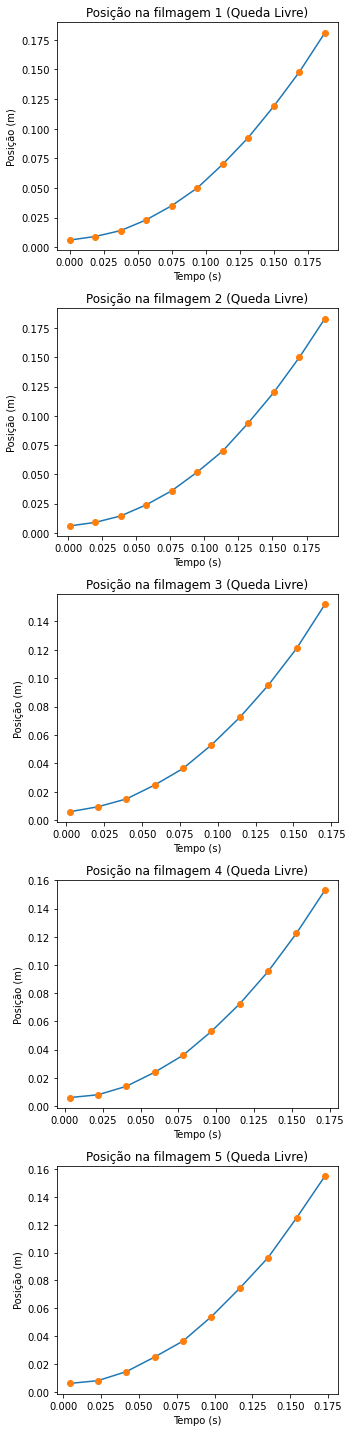

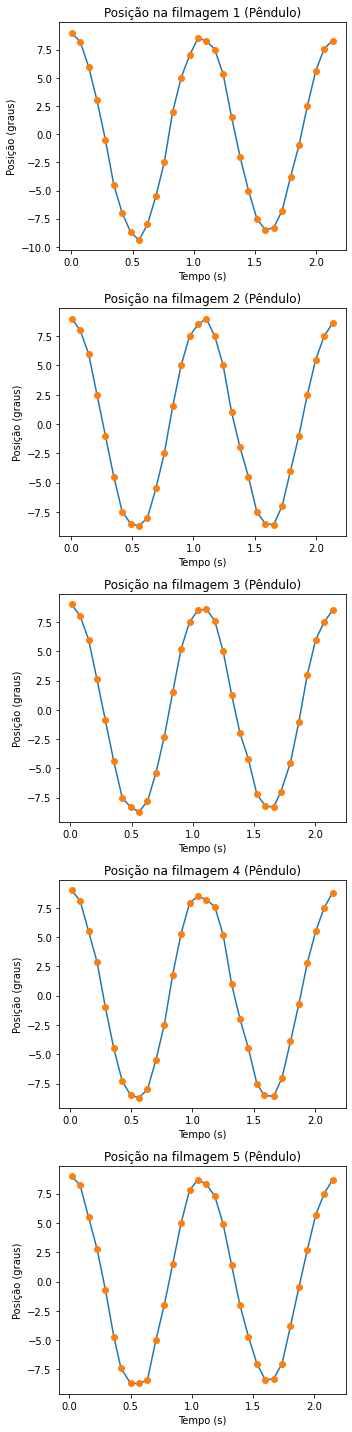

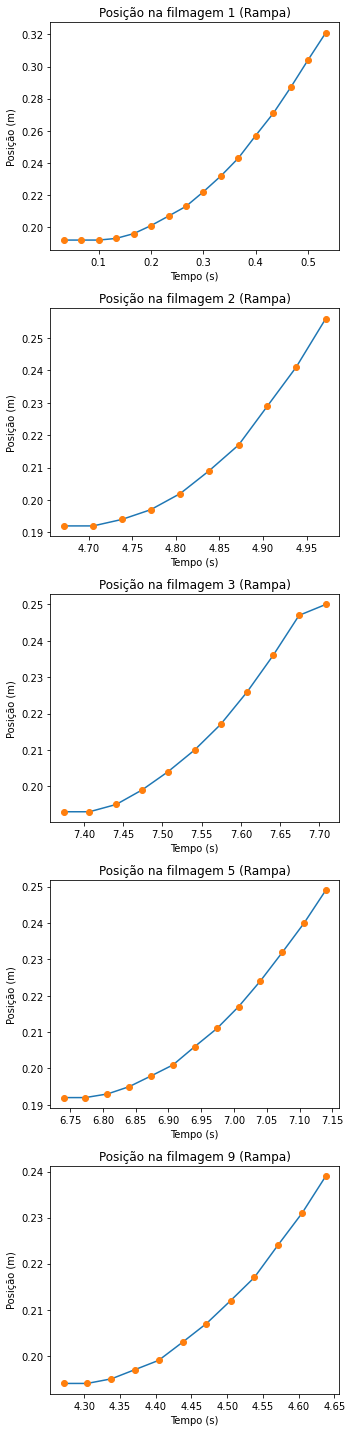

In [101]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Posição (m)', 'position', 'Queda Livre', [1, 2, 3, 4, 5], "Posição", False)
plotCol(dfPendulo, 'Tempo (s)', 'Posição (graus)', 'angle', 'Pêndulo', [1, 2, 3, 4, 5], "Posição", False)
plotCol(dfAtrito, 'Tempo (s)', 'Posição (m)', 'position', 'Rampa', [1, 2, 3, 5, 9], "Posição", False)

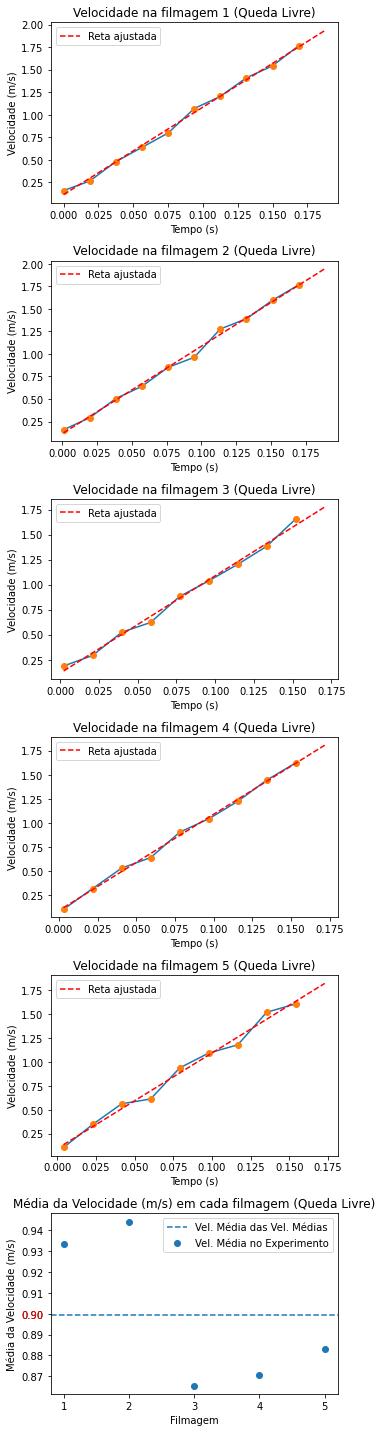

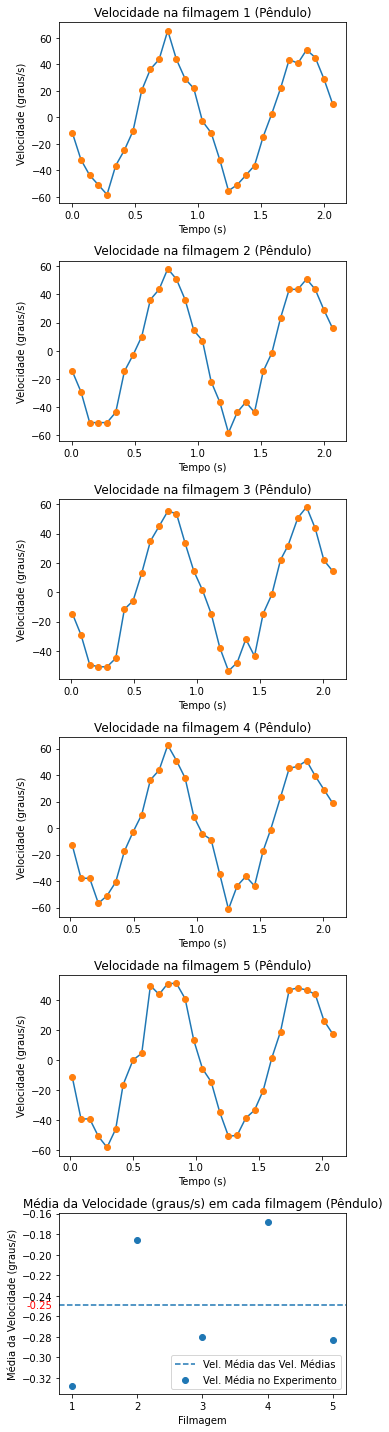

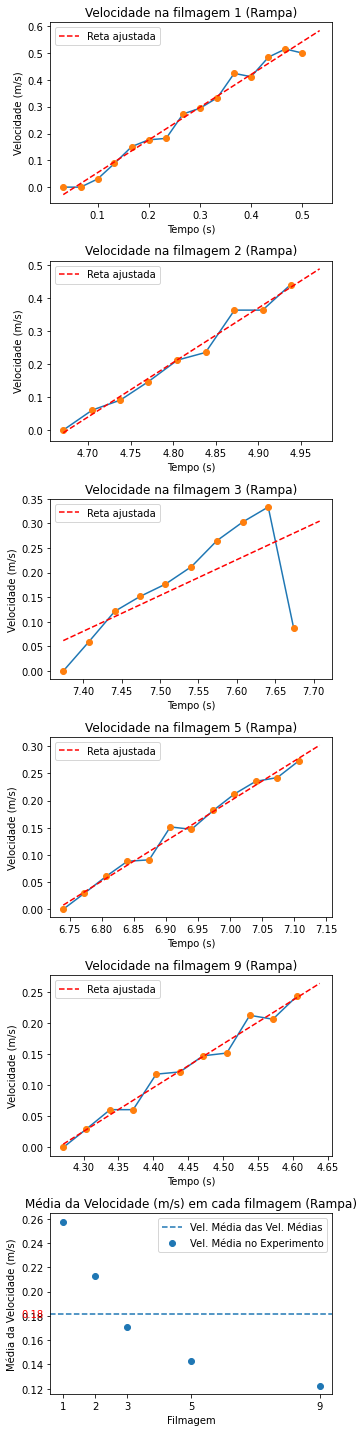

In [102]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Velocidade (m/s)', 'velocity', 'Queda Livre', [1,2,3,4,5], 'Velocidade', plotFit = True)
plotCol(dfPendulo, 'Tempo (s)', 'Velocidade (graus/s)', 'velocity', 'Pêndulo', [1,2,3,4,5], 'Velocidade')
plotCol(dfAtrito, 'Tempo (s)', 'Velocidade (m/s)', 'velocity', 'Rampa', [1,2,3,5,9], 'Velocidade', plotFit = True)

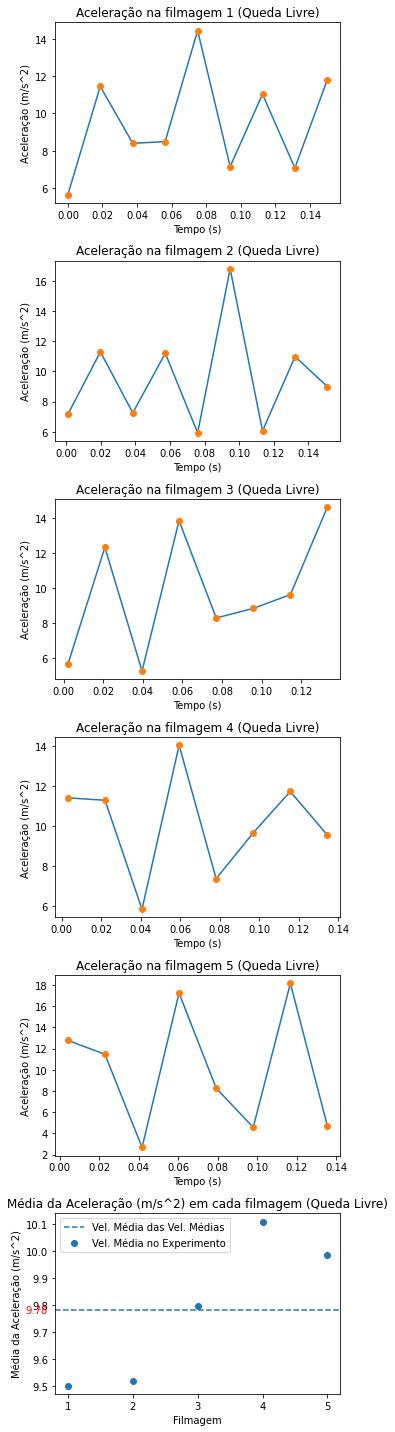

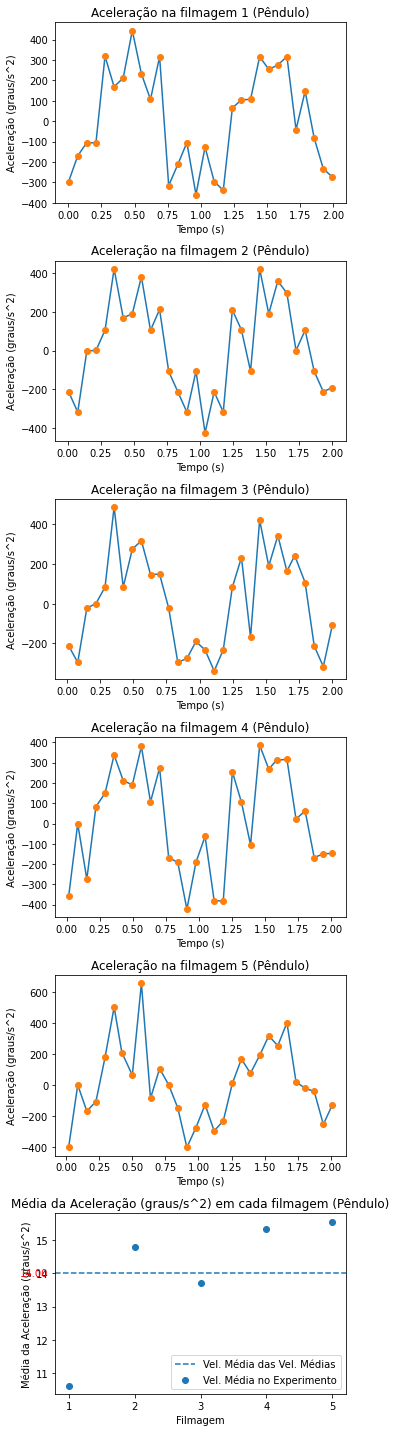

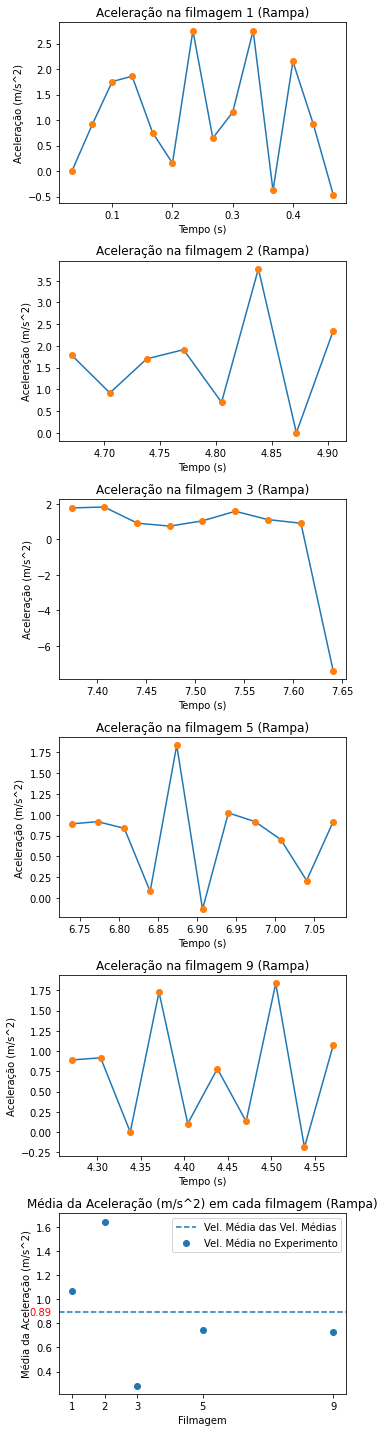

In [103]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Aceleração (m/s^2)', 'acceleration', 'Queda Livre', [1,2,3,4,5], 'Aceleração')
plotCol(dfPendulo, 'Tempo (s)', 'Aceleração (graus/s^2)', 'acceleration', 'Pêndulo', [1,2,3,4,5], 'Aceleração')
plotCol(dfAtrito, 'Tempo (s)', 'Aceleração (m/s^2)', 'acceleration', 'Rampa', [1,2,3,5,9], 'Aceleração') 

In [104]:
dfQuedaLivre.to_csv('DATA/ffWVel.csv', index = False)
dfPendulo.to_csv('DATA/pWVel.csv', index = False)

In [105]:
import unittest
class TestNotebook(unittest.TestCase):
    
    def test_createVelCol(self):
        d = {'position':[2,4,8],
             'time' : [0,1,2],
             'experiment' : 1}
        
        df = pd.DataFrame(d)
        
        vel = [2.0, 4.0, np.NaN]
        createVelCol(df, 'position')
                
        vel2 = df['velocity'].to_numpy()
        
        self.assertEqual(2.0, vel[0])
        self.assertEqual(4.0, vel[1])
        self.assertTrue(np.isnan(vel[2]))
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_createVelCol (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
